In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import load_npy, print_classification_report, plot_confusion_matrix, get_f1_score
import torch
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Model

In [3]:
reduced_model_params = 11_852_814
full_model_params = 152_086_874

reduction_percentage = (full_model_params - reduced_model_params) / full_model_params * 100
print(f"The model size was reduced by {reduction_percentage:.2f}%")

The model size was reduced by 92.21%


# Load Data

In [4]:
from data import SequenceClassificationDataset

root = './'
cl_train_dataset = SequenceClassificationDataset(Path(root, 'train_scibert.json'))
cl_dev_dataset = SequenceClassificationDataset(Path(root, 'dev_scibert.json'))
cl_test_dataset = SequenceClassificationDataset(Path(root, 'test_scibert.json'))

batch_size=1
train_dataloader = DataLoader(cl_train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(cl_dev_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(cl_test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
datastore_keys = torch.from_numpy(load_npy('newbaseline_datastore_keys.npy'))
datastore_values = torch.from_numpy(load_npy('newbaseline_datastore_values.npy'))

datastore_keys.shape, datastore_values.shape

(torch.Size([1, 10540, 768]), torch.Size([1, 10540]))

In [6]:
embeddings = torch.from_numpy(load_npy('newbaseline_test_embeddings.npy'))
labels = torch.from_numpy(load_npy('newbaseline_test_labels.npy'))
logits = torch.from_numpy(load_npy('newbaseline_test_logits.npy'))
predicted_labels = torch.from_numpy(load_npy('newbaseline_test_predicted_labels.npy'))

embeddings.shape, labels.shape, logits.shape, predicted_labels.shape

(torch.Size([1, 1338, 768]),
 torch.Size([1, 1338]),
 torch.Size([1, 1338, 7]),
 torch.Size([1, 1338]))

# Baseline Only

In [7]:
print_classification_report(labels, predicted_labels)

              precision    recall  f1-score   support

        Fact       0.67      0.56      0.61       326
    Argument       0.93      0.83      0.88       201
   Precedent       1.00      0.09      0.17       256
       Ratio       0.53      0.99      0.69       434
     RulingL       0.00      0.00      0.00        23
     RulingP       0.00      0.00      0.00        12
     Statute       0.87      0.63      0.73        86

    accuracy                           0.64      1338
   macro avg       0.57      0.44      0.44      1338
weighted avg       0.72      0.64      0.59      1338



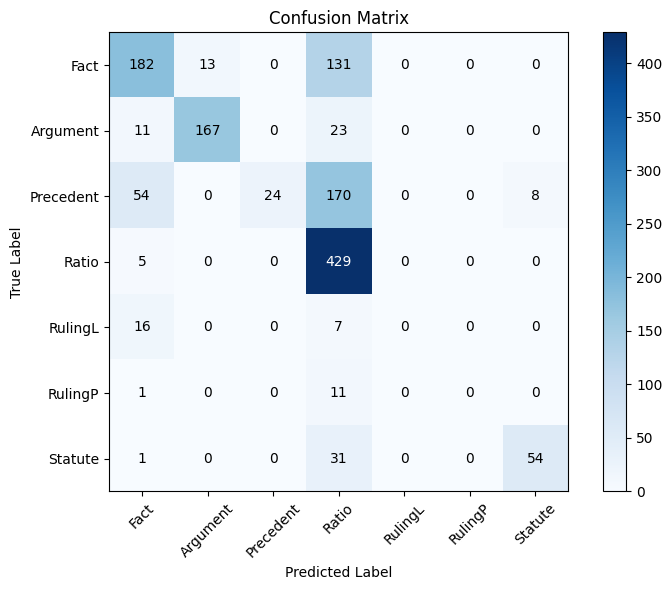

In [8]:
plot_confusion_matrix(labels, predicted_labels)

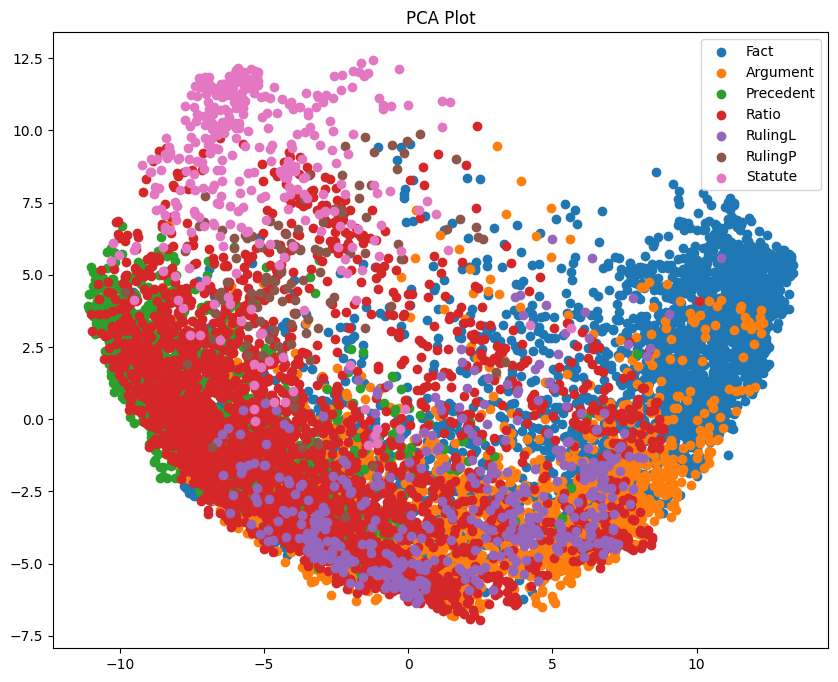

In [10]:
from plot import plot_embeddings_pca

plot_embeddings_pca(datastore_keys, datastore_values)

# Mean Prototype at inference time

In [11]:
# get number of unique labls
num_labels = torch.unique(datastore_values).size(0)
# placeholder zero embedding for each different label
avg_embeddings = torch.zeros(num_labels, datastore_keys.size(2))


# iterate over the unique labels
for i, label in enumerate(torch.unique(datastore_values)):
    # get a mask for the label
    label_mask = torch.eq(datastore_values, label)
    # choose embeddings matching the mask
    filtered_embeddings = datastore_keys[label_mask].squeeze(0)
    # calcualte the mean of the chosen embeddings
    avg_embedding = torch.mean(filtered_embeddings, dim=0)
    # save the average in the placeholder
    avg_embeddings[i] = avg_embedding
    
print(avg_embeddings.shape)

torch.Size([7, 768])


In [48]:
def get_logits(logits, embeddings, avg_embeddings, num_labels, lambda_):
  
  embeddings = embeddings.squeeze(0)
  examples = embeddings.size(0) 
  embeddings = embeddings.unsqueeze(1)

  distances = torch.norm(embeddings - avg_embeddings, dim=2).unsqueeze(0)  

  # transform scores to softmax probabilities
  proto_probabilities = torch.softmax(-distances, dim=-1)
  # interpolate between logits and knn_probabilites
  probabilities = lambda_*logits + (1-lambda_)*proto_probabilities

  # argmax to get most likely label
  argmax_labels = torch.argmax(probabilities, 2, keepdim=False)

  # return predicted labels
  return argmax_labels

In [59]:
f1s = {}
for lambda_ in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    predicted_labels_protoype_average = get_logits(logits, embeddings, avg_embeddings, 7, lambda_)
    f1 = get_f1_score(labels, predicted_labels_protoype_average)
    f1s[lambda_] = f1

In [64]:
best_lambda = max(f1s, key=f1s.get)
best_lambda

0.4

In [65]:
predicted_labels_protoype_average = get_logits(logits, embeddings, avg_embeddings, 7, best_lambda)

In [66]:
print_classification_report(labels, predicted_labels_protoype_average)

              precision    recall  f1-score   support

        Fact       0.66      0.57      0.61       326
    Argument       0.90      0.84      0.87       201
   Precedent       0.68      0.44      0.53       256
       Ratio       0.62      0.85      0.72       434
     RulingL       0.00      0.00      0.00        23
     RulingP       0.86      0.50      0.63        12
     Statute       0.65      0.73      0.69        86

    accuracy                           0.68      1338
   macro avg       0.62      0.56      0.58      1338
weighted avg       0.68      0.68      0.66      1338



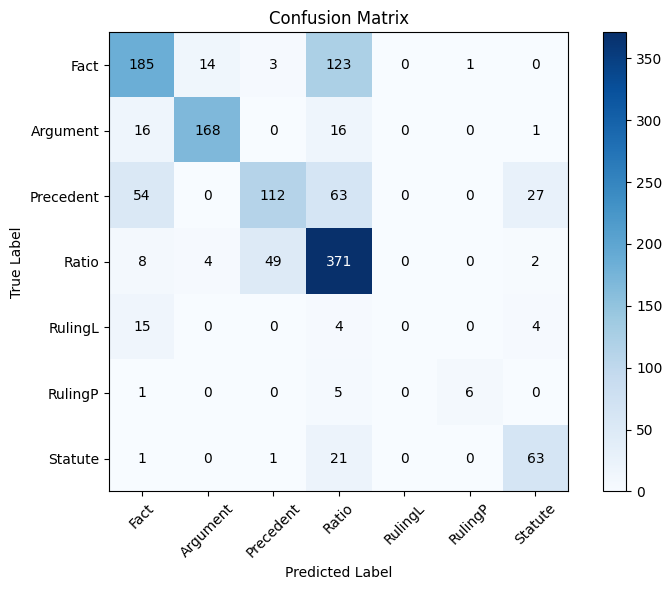

In [67]:
plot_confusion_matrix(labels, predicted_labels_protoype_average)

# KNN at inference time

In [72]:
def get_logits(logits, embeddings, datastore_keys, datastore_values, num_labels,K, lambda_, link_temperature=1.0):
  # cosine similarity
  knn_feats = datastore_keys.squeeze(0).transpose(0, 1) # [feature_size=768, datastore_size]
  embeddings = embeddings.view(-1, embeddings.shape[-1])  # [sentences, feature_size=768]
  sim = torch.mm(embeddings, knn_feats) # [sentences, datastore_size]

  sentences = embeddings.shape[0]
  datastore_size = knn_feats.shape[1]

  norm_1 = (knn_feats ** 2).sum(dim=0, keepdim=True).sqrt() # [1, datastore_size]
  norm_2 = (embeddings ** 2).sum(dim=1, keepdim=True).sqrt() # [sentences, 1]
  scores = (sim / (norm_1 + 1e-10) / (norm_2 + 1e-10)).view(1, sentences, -1) # [1, sentences, datastore_size]
  knn_labels = datastore_values.view(1, 1, datastore_size).expand(1, sentences, datastore_size) # [1, sentences, datastore_size]

  # select scores and labels of the top k only
  topk_scores, topk_idxs = torch.topk(scores, dim=-1, k=K)  # [1, sentences, topk]
  scores = topk_scores
  knn_labels = knn_labels.gather(dim=-1, index=topk_idxs)  # [[1, sentences, topk]

  # transform scores to softmax probabilities
  sim_probs = torch.softmax(scores / link_temperature, dim=-1) # [[1, sentences, topk]

  # 1. create zero tensor for probabilites as placeholder
  knn_probabilities = torch.zeros_like(sim_probs[:, :, 0]).unsqueeze(-1).repeat([1, 1, num_labels])  # [1, sentences, num_labels]
  # for each row (dim=2)
  # sum the probabilities from sim softmax probabilities (src=sim_probs) grouped by class (index=knn_labels)
  knn_probabilities = knn_probabilities.scatter_add(dim=2, index=knn_labels, src=sim_probs) # [1, sentences, num_labels]

  # interpolate between logits and knn_probabilites
  probabilities = lambda_*logits + (1-lambda_)*knn_probabilities

  # argmax to get most likely label
  argmax_labels = torch.argmax(probabilities, 2, keepdim=False)

  # return predicted labels
  return argmax_labels

In [74]:
f1s = {}
for lambda_ in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    for k in [5,10,24,124,256,512]:
        predicted_labels_protoype_average = get_logits(logits, embeddings, datastore_keys, datastore_values, 7, k, lambda_)
        f1 = get_f1_score(labels, predicted_labels_protoype_average)
        f1s[str(k)+'_'+str(lambda_)] = f1

In [76]:
best_lambda = max(f1s, key=f1s.get)
best_lambda, f1s[best_lambda]

('512_0.1', 0.6904307138959479)

In [79]:
predicted_labels_knn = get_logits(logits, embeddings, datastore_keys, datastore_values, 7, 512, 0.1)

In [80]:
print_classification_report(labels, predicted_labels_knn)

              precision    recall  f1-score   support

        Fact       0.66      0.60      0.63       326
    Argument       0.93      0.86      0.89       201
   Precedent       0.92      0.47      0.62       256
       Ratio       0.61      0.95      0.74       434
     RulingL       0.00      0.00      0.00        23
     RulingP       0.00      0.00      0.00        12
     Statute       0.89      0.55      0.68        86

    accuracy                           0.71      1338
   macro avg       0.57      0.49      0.51      1338
weighted avg       0.73      0.71      0.69      1338



 ## TODO: plot macro-f1, weighted-f1  over k in KNN

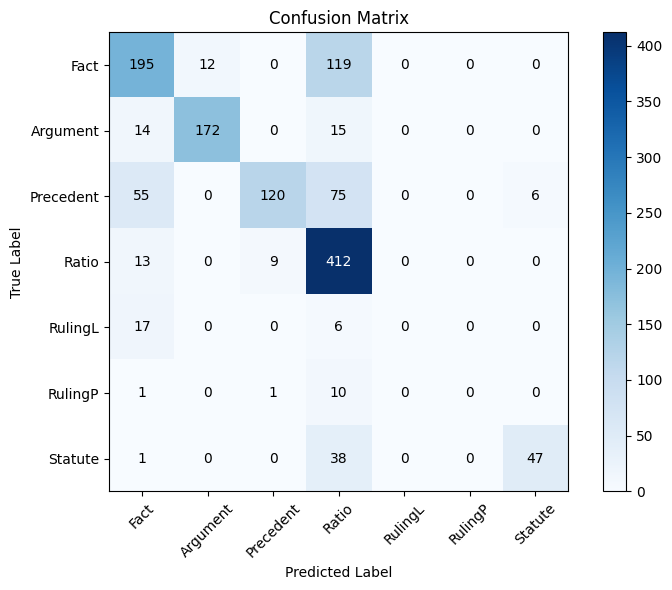

In [81]:
plot_confusion_matrix(labels, predicted_labels_knn)

# Multiple Prototypes per class

In [25]:
import torch
from sklearn.cluster import KMeans
from collections import defaultdict

def cluster_embeddings(datastore_keys, datastore_values, num_clusters):
    """
    Cluster embeddings based on their labels using a specified number of clusters.

    Parameters:
        datastore_keys (torch.Tensor): Embeddings tensor of shape (1, 10540, 768).
        datastore_values (torch.Tensor): Labels tensor of shape (1, 10540).
        num_clusters (int): Number of clusters to create for each group.

    Returns:
        dict: A dictionary containing cluster centroids for each unique label.
    """
    # Convert tensors to NumPy arrays
    embeddings = datastore_keys.numpy().squeeze(0)
    labels = datastore_values.numpy().squeeze(0)

    # Create a dictionary to store cluster centroids for each unique label
    cluster_centroids = defaultdict(list)

    # Group embeddings based on their labels
    unique_labels = set(labels)
    for label in unique_labels:
        # Get indices of embeddings with the current label
        indices = torch.nonzero(torch.from_numpy(labels == label)).flatten()

        # Extract embeddings with the current label
        embeddings_with_label = embeddings[indices]

        # Cluster embeddings with the current label
        kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
        kmeans.fit(embeddings_with_label)

        # Get cluster centroids for the current label
        centroids = kmeans.cluster_centers_
        #print(len(centroids))

        # Store cluster centroids in the dictionary
        cluster_centroids[label] = centroids

    return cluster_centroids


import torch
from sklearn.metrics.pairwise import euclidean_distances

def calculate_distances_from_centroids(cluster_centroids, embeddings):
    """
    Calculate distances between embeddings and cluster centroids.

    Parameters:
        cluster_centroids (dict): Dictionary containing cluster centroids for each label.
        embeddings (torch.Tensor): Embeddings tensor of shape (1, 1338, 768).

    Returns:
        torch.Tensor: Tensor representing the distances from each embedding to all centroids.
    """
    # Convert cluster centroids to a PyTorch tensor
    centroids = np.concatenate(list(cluster_centroids.values()))
    # Convert embeddings tensor to a PyTorch tensor and squeeze the dimension
    embeddings = embeddings.squeeze(0)

    # Calculate distances between embeddings and centroids
    distances = euclidean_distances(embeddings, centroids)

    # Convert distances to a PyTorch tensor
    distances_tensor = torch.tensor(distances)

    return distances_tensor

def multi_proto(num_clusters, lambda_, logits):
    
    '''
    Inputs: 
        logits: tensor of shape  torch.Size([M, n])
        lambda: in [0,1]
    Returns:
        prediced interpolated labels:  torch.Size([M])
        
    symbol definitions:
        K: number of centroids per label
        E: size of embeddings
        M: number of data examples
        n: number of labels
    '''
    # defaultdict(list)
    # each key: (K, E)
    clusters = cluster_embeddings(datastore_keys, datastore_values, num_clusters)
    #  torch.Size([M, n*K])
    distances = calculate_distances_from_centroids(clusters, embeddings)
    
    # torch.Size([M, n*K])
    probabilities = F.softmax(distances, dim=1)
    
    # torch.Size([M, n, K])
    reshaped_probs = probabilities.view(probabilities.shape[0], 7, -1)
    
    # torch.Size([M, n])
    summed_probs = torch.sum(reshaped_probs, dim=2)
    
    # interpolate between logits and knn_probabilites
    # torch.Size([M, n])
    probabilities = lambda_*logits + (1-lambda_)*summed_probs
    
    # argmax to get most likely label
    # torch.Size([M])
    
    argmax_labels = torch.argmax(probabilities, 2, keepdim=False)
    return argmax_labels

In [28]:
from sklearn.metrics import f1_score
from tqdm import tqdm
import torch.nn.functional as F
def fintune_kmeans():
    results = {}
    for lambda_ in tqdm([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
        results[lambda_] = {}
        for num_clusters in [3,5,7,10]:
            kmeans_augmented_labels = multi_proto(num_clusters, lambda_, logits)
            f1 = f1_score(labels.squeeze(), kmeans_augmented_labels.squeeze(), average='weighted')
            results[lambda_][num_clusters] = f1
    return results

In [29]:
kmeans_f1 = fintune_kmeans()

100%|███████████████████████████████████████████| 11/11 [00:33<00:00,  3.06s/it]


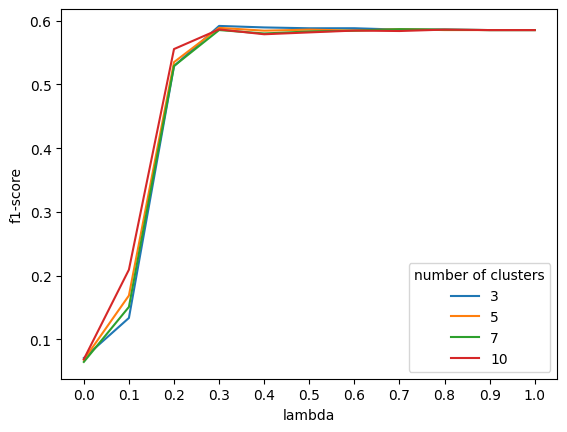

In [30]:
import matplotlib.pyplot as plt

# get inner keys
inner_keys = list(kmeans_f1.values())[0].keys()

# x-axis is the outer keys
x_axis_values = list(map(str, kmeans_f1.keys()))

# loop through inner_keys
for x in inner_keys:

    # create a list of values for inner key
    y_axis_values = [v[x] for v in kmeans_f1.values()]
    # plot each inner key
    plt.plot(x_axis_values, y_axis_values, label=x)

plt.xlabel('lambda')
plt.ylabel('f1-score')
plt.legend(title="number of clusters")

In [31]:
max_value = float('-inf')
max_keys = None

for key1, sub_dict in kmeans_f1.items():
    for key2, value in sub_dict.items():
        if value > max_value:
            max_value = value
            max_keys = (key1, key2)

max_value, max_keys

(0.5918703098910053, (0.3, 3))

In [32]:
kmeans_augmented_labels = multi_proto(max_keys[1], max_keys[0], logits)

In [33]:
print_classification_report(labels.squeeze(), kmeans_augmented_labels.squeeze())

              precision    recall  f1-score   support

        Fact       0.65      0.63      0.64       326
    Argument       0.93      0.84      0.88       201
   Precedent       1.00      0.09      0.16       256
       Ratio       0.55      0.96      0.70       434
     RulingL       0.00      0.00      0.00        23
     RulingP       0.00      0.00      0.00        12
     Statute       0.86      0.58      0.69        86

    accuracy                           0.65      1338
   macro avg       0.57      0.44      0.44      1338
weighted avg       0.72      0.65      0.59      1338



## TODO: variable number of cluster to clusters

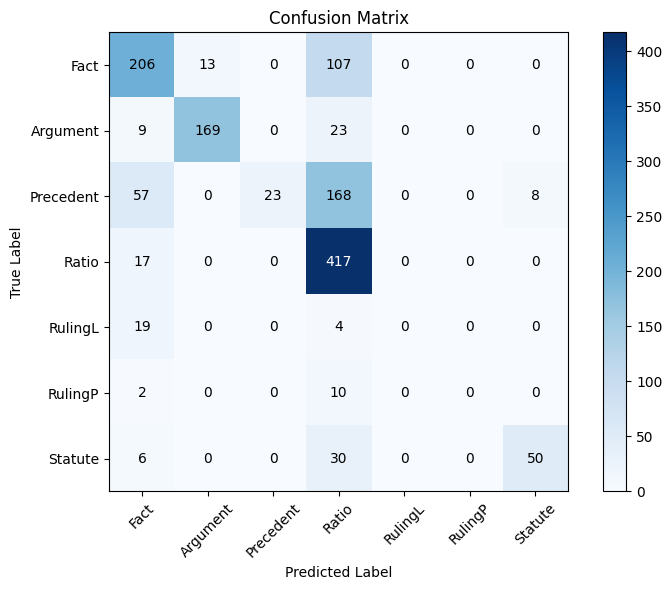

In [34]:
plot_confusion_matrix(labels, kmeans_augmented_labels)